## Understanding the Probability Distribution

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
Physics_std = 5
Physics_mean = 80

Physics = np.round(np.random.randn(500)*Physics_std + Physics_mean)

Maths = np.round(np.random.randn(500)*10 + 40)

In [4]:
print(Physics)
print(Maths)

[82. 85. 85. 87. 79. 72. 73. 84. 71. 77. 75. 79. 83. 82. 87. 69. 81. 78.
 81. 79. 89. 76. 81. 79. 83. 72. 83. 82. 84. 73. 83. 84. 72. 78. 75. 77.
 83. 85. 79. 81. 79. 79. 80. 79. 67. 81. 77. 74. 82. 86. 77. 84. 77. 82.
 89. 88. 81. 85. 75. 73. 74. 88. 81. 76. 82. 85. 90. 75. 80. 86. 80. 82.
 77. 82. 82. 78. 79. 69. 75. 78. 81. 80. 81. 78. 90. 85. 78. 78. 79. 78.
 80. 78. 82. 77. 77. 90. 80. 85. 84. 74. 81. 74. 84. 84. 74. 76. 79. 81.
 75. 72. 81. 80. 84. 83. 80. 82. 84. 79. 82. 86. 87. 86. 81. 81. 78. 84.
 74. 83. 76. 73. 81. 90. 70. 83. 78. 82. 77. 74. 81. 71. 82. 78. 88. 78.
 80. 86. 81. 76. 75. 79. 72. 85. 80. 86. 74. 81. 74. 77. 79. 83. 70. 76.
 74. 74. 86. 79. 81. 69. 79. 73. 90. 87. 83. 82. 73. 70. 80. 73. 83. 78.
 84. 83. 71. 84. 79. 84. 81. 74. 77. 78. 74. 83. 77. 77. 73. 81. 83. 80.
 88. 87. 78. 76. 74. 79. 72. 84. 85. 77. 77. 82. 79. 79. 73. 77. 84. 79.
 78. 85. 67. 86. 78. 89. 83. 76. 83. 75. 80. 81. 78. 89. 85. 76. 75. 75.
 83. 81. 72. 85. 82. 84. 78. 80. 71. 78. 83. 78. 81

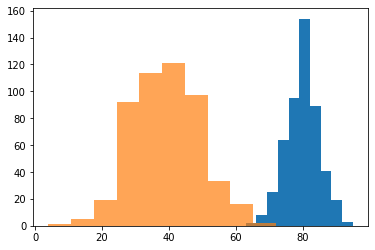

In [5]:
plt.hist(Physics)
plt.hist(Maths,alpha=0.7)
plt.show()

# Understanding GANs

In [0]:
## GAN Training 

1. Generate a Mini Batch from Generator using Noise-Prior (Ground Truth - 0)
2. Select a Mini Batch form Real Training Data (Ground Truth - 1)
3. Train only Discriminator on both batches separately
    - Consider Generator as Frozen
    
4. Train G using random noise as input and 1 as ground truth as 1 for all examples
    - Consider Discriminator as Frozen

## **GAN Training**

**GAN Paper**[https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf] 

Generative Adversarial Nets Ian Goodfellow

1. Generate a Mini Batch from Generator using Noise-Prior (Ground Truth - 0)
2. Select a Mini Batch form Real Training Data (Ground Truth - 1)
3. Train only Discriminator on both batches separately
> - Consider Generator as Frozen
4. Train G using random noise as input and 1 as ground truth for all examples
> - Consider Discriminator as Frozen

### **Training Tricks**
- Normalize inputs between [-1,1] and use tanh as activation for generator
- Noise should be sample from Gaussian Distribtution
- Avoid Sparse Gradients
> - Prefer Leaky ReLU
> - Prefer Strided Convolutions instead of max pooling
> - Use Adam for optimization
> - One Sided Label Smoothing - Use 0 and 0.9 instead of 0 and 1 for discriminator

### We will we be using MNIST Dataset

In [0]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import math

In [0]:
#Load The Dataset
(X_Train,_),(_,_) = mnist.load_data()

In [56]:
print(X_Train.shape)

(60000, 28, 28)


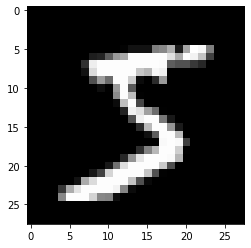

In [57]:
plt.imshow(X_Train[0],cmap='gray')

In [58]:
#Normalize the data [-1,1]
X_Train = (X_Train.astype('float32') - 127.5)/127.5

print(np.min(X_Train))
print(np.max(X_Train))

print(X_Train.shape)

-1.0
1.0
(60000, 28, 28)


In [0]:
# Defining the some values
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = int(X_Train.shape[0]/BATCH_SIZE)
HALF_BATCH = int(BATCH_SIZE/2)
NOISE_DIM = 100 # Upsample into 784 Dim Vector
adam =  Adam(lr=2e-4,beta_1=0.5)

In [60]:
# Generator
# Input Noise (100 dim) and Outputs (784 dim)

generator =  Sequential()
generator.add(Dense(256,input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784,activation='tanh'))

generator.compile(loss='binary_crossentropy',optimizer=adam)
generator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 784)              

In [61]:
# Downsampling
discriminator = Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer=adam)

discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [0]:
# GAN (Step-2)
discriminator.trainable = False
gan_input  = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

# Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

In [63]:
# Reshaping the Model for giving it as input in Model
X_Train = X_Train.reshape(-1,784)
print(X_Train.shape)

(60000, 784)


In [0]:
def save_imgs(epoch,samples=100):
  ''' To save images after training of one epoch '''
  noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
  generated_imgs = generator.predict(noise)
  generated_imgs = generated_imgs.reshape(samples,28,28)

  plt.figure(figsize=(10,10))
  for i in range(samples):
    plt.subplot(10,10,i+1)
    plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
    plt.axis('off')

  plt.tight_layout()
  plt.savefig('images/gan_output_epoch_{0}.png'.format(epoch+1))
  plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 Disc Loss 0.6540 Generator Loss 0.9411
Epoch 2 Disc Loss 0.6508 Generator Loss 1.0170
Epoch 3 Disc Loss 0.6363 Generator Loss 1.0976
Epoch 4 Disc Loss 0.6221 Generator Loss 1.1491
Epoch 5 Disc Loss 0.6064 Generator Loss 1.1971


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


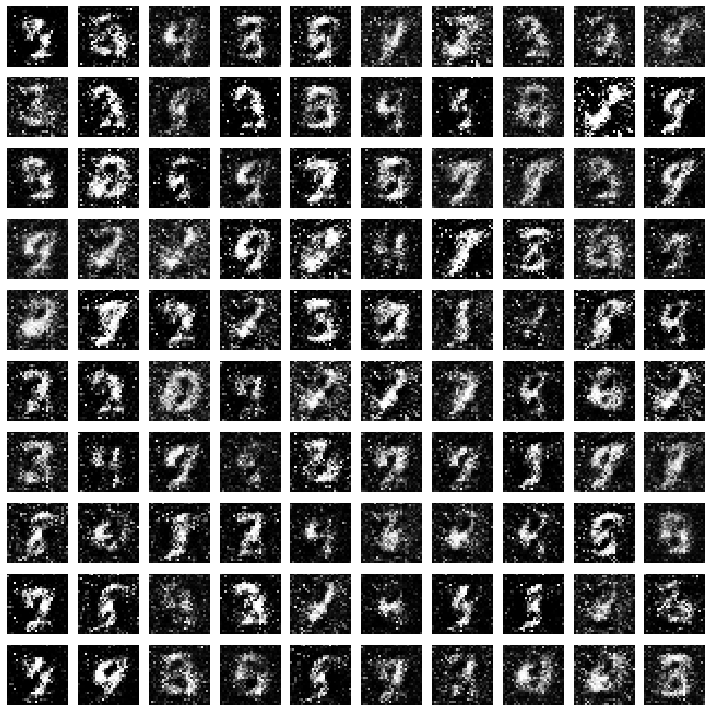

Epoch 6 Disc Loss 0.5948 Generator Loss 1.2097
Epoch 7 Disc Loss 0.5835 Generator Loss 1.2301
Epoch 8 Disc Loss 0.6064 Generator Loss 1.1798
Epoch 9 Disc Loss 0.6133 Generator Loss 1.1625
Epoch 10 Disc Loss 0.6262 Generator Loss 1.1070


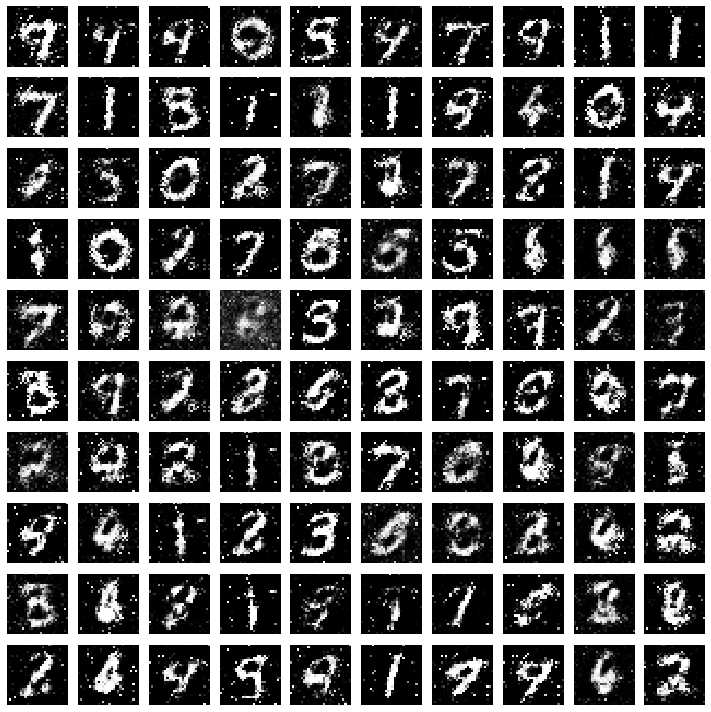

Epoch 11 Disc Loss 0.6345 Generator Loss 1.0807
Epoch 12 Disc Loss 0.6360 Generator Loss 1.0647
Epoch 13 Disc Loss 0.6389 Generator Loss 1.0290
Epoch 14 Disc Loss 0.6444 Generator Loss 1.0337
Epoch 15 Disc Loss 0.6487 Generator Loss 1.0195


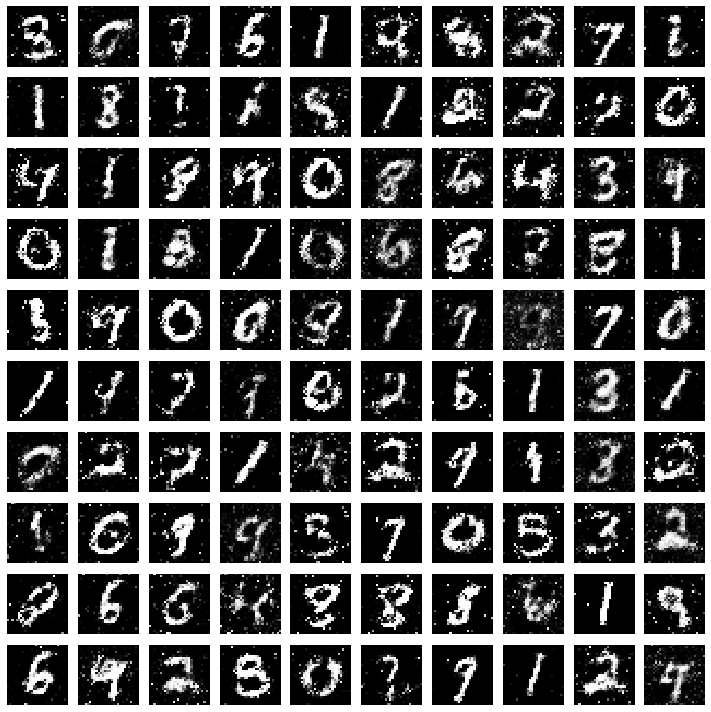

Epoch 16 Disc Loss 0.6452 Generator Loss 1.0186
Epoch 17 Disc Loss 0.6460 Generator Loss 1.0181
Epoch 18 Disc Loss 0.6425 Generator Loss 1.0391
Epoch 19 Disc Loss 0.6430 Generator Loss 1.0364
Epoch 20 Disc Loss 0.6467 Generator Loss 1.0250


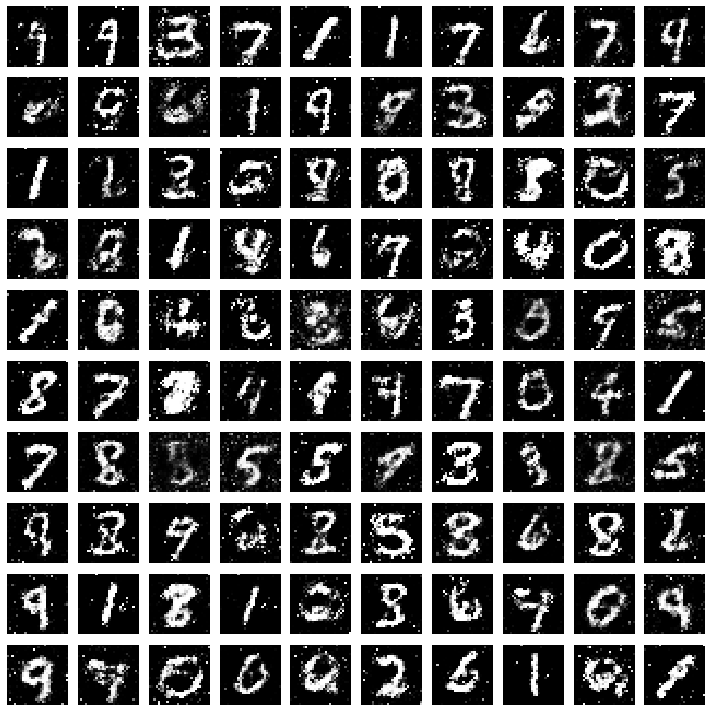

Epoch 21 Disc Loss 0.6468 Generator Loss 1.0265
Epoch 22 Disc Loss 0.6513 Generator Loss 1.0122
Epoch 23 Disc Loss 0.6532 Generator Loss 1.0133
Epoch 24 Disc Loss 0.6510 Generator Loss 1.0092
Epoch 25 Disc Loss 0.6526 Generator Loss 1.0152


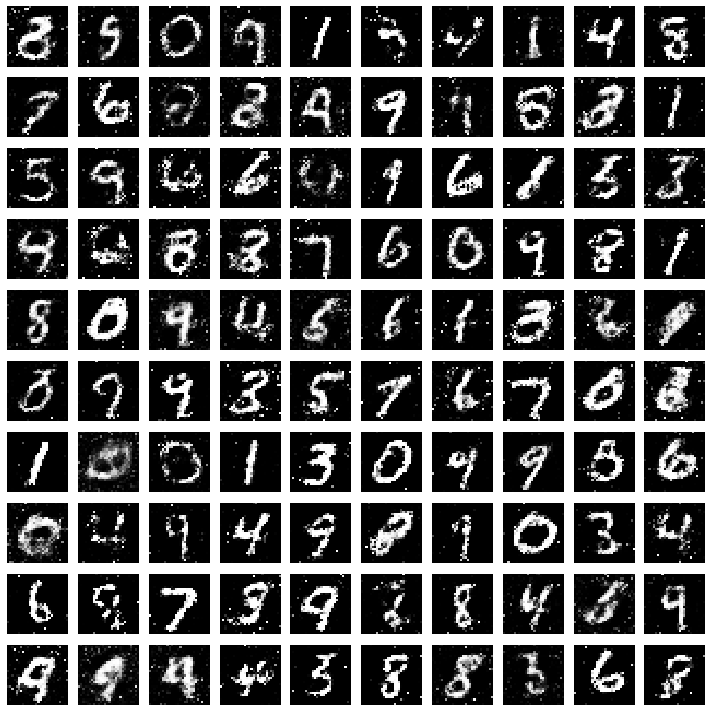

Epoch 26 Disc Loss 0.6537 Generator Loss 1.0035
Epoch 27 Disc Loss 0.6557 Generator Loss 1.0060
Epoch 28 Disc Loss 0.6536 Generator Loss 1.0078
Epoch 29 Disc Loss 0.6546 Generator Loss 1.0048
Epoch 30 Disc Loss 0.6560 Generator Loss 1.0029


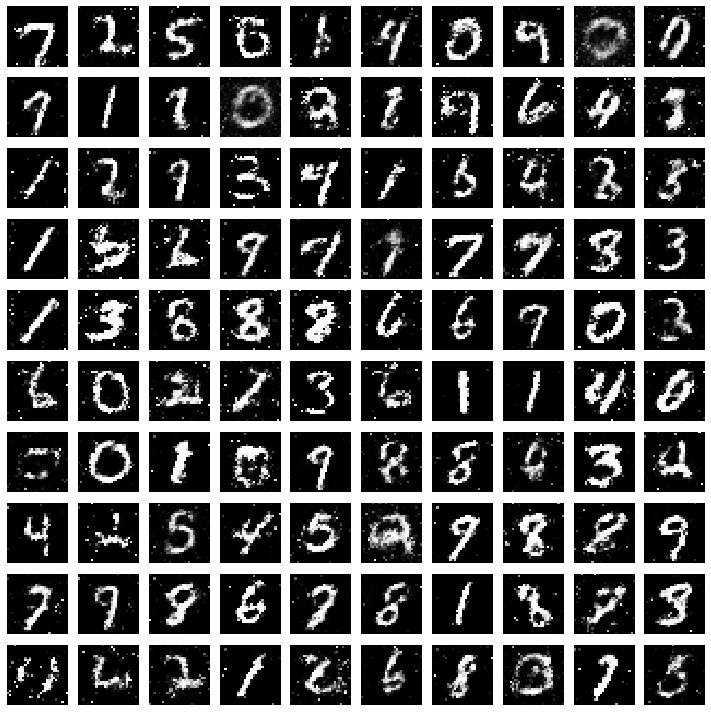

Epoch 31 Disc Loss 0.6548 Generator Loss 1.0086
Epoch 32 Disc Loss 0.6573 Generator Loss 1.0010
Epoch 33 Disc Loss 0.6574 Generator Loss 1.0060
Epoch 34 Disc Loss 0.6585 Generator Loss 0.9963
Epoch 35 Disc Loss 0.6611 Generator Loss 0.9959


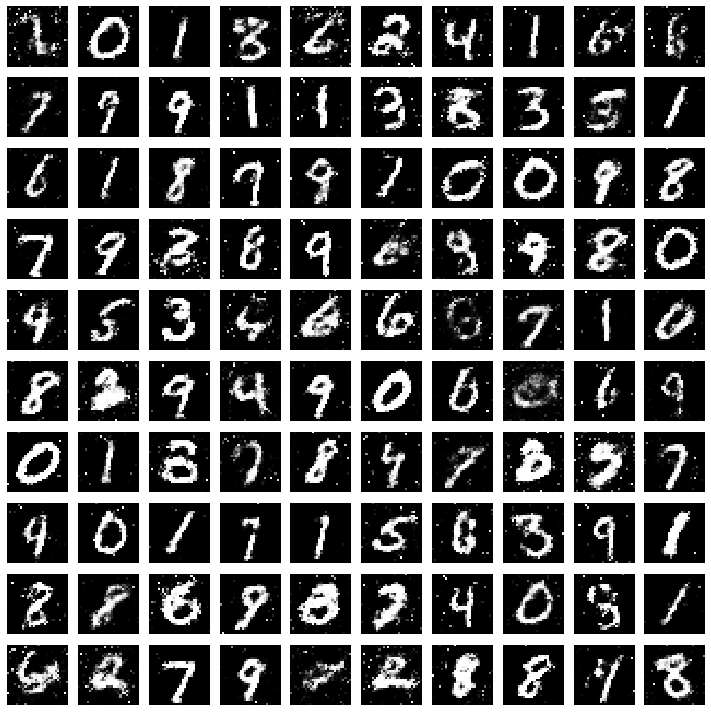

Epoch 36 Disc Loss 0.6609 Generator Loss 0.9953
Epoch 37 Disc Loss 0.6604 Generator Loss 0.9985
Epoch 38 Disc Loss 0.6595 Generator Loss 0.9983
Epoch 39 Disc Loss 0.6610 Generator Loss 0.9959
Epoch 40 Disc Loss 0.6593 Generator Loss 0.9982


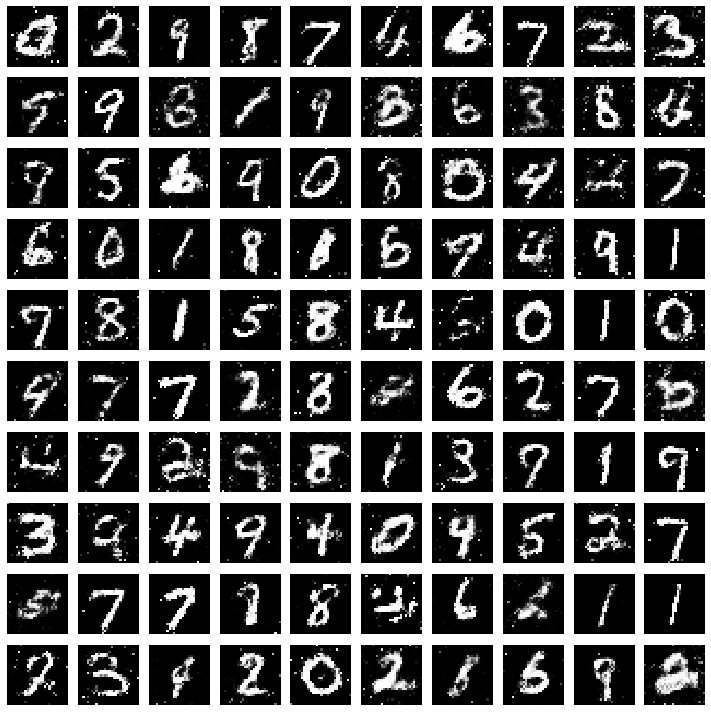

Epoch 41 Disc Loss 0.6603 Generator Loss 0.9964
Epoch 42 Disc Loss 0.6604 Generator Loss 0.9928
Epoch 43 Disc Loss 0.6596 Generator Loss 1.0009
Epoch 44 Disc Loss 0.6602 Generator Loss 0.9997
Epoch 45 Disc Loss 0.6605 Generator Loss 1.0007


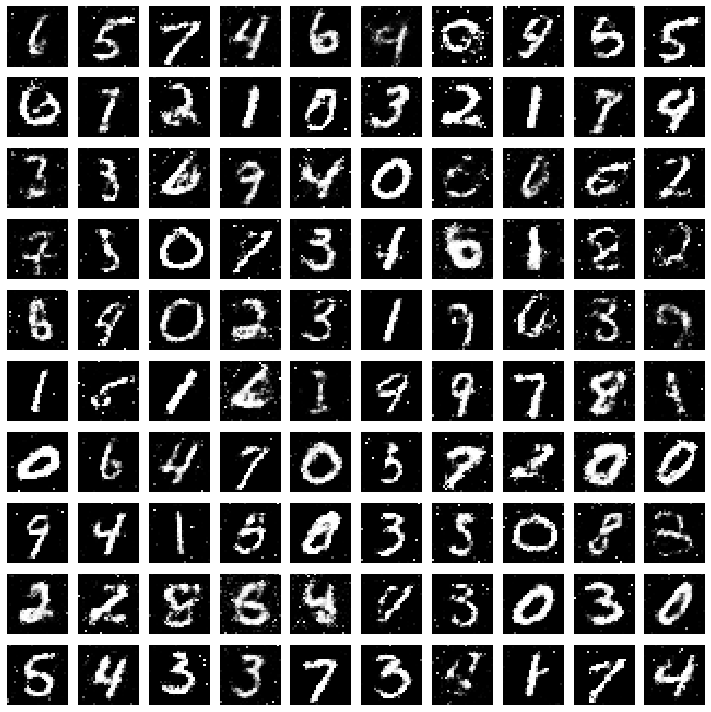

Epoch 46 Disc Loss 0.6597 Generator Loss 0.9999
Epoch 47 Disc Loss 0.6594 Generator Loss 0.9956
Epoch 48 Disc Loss 0.6603 Generator Loss 1.0010
Epoch 49 Disc Loss 0.6616 Generator Loss 0.9971
Epoch 50 Disc Loss 0.6612 Generator Loss 0.9922


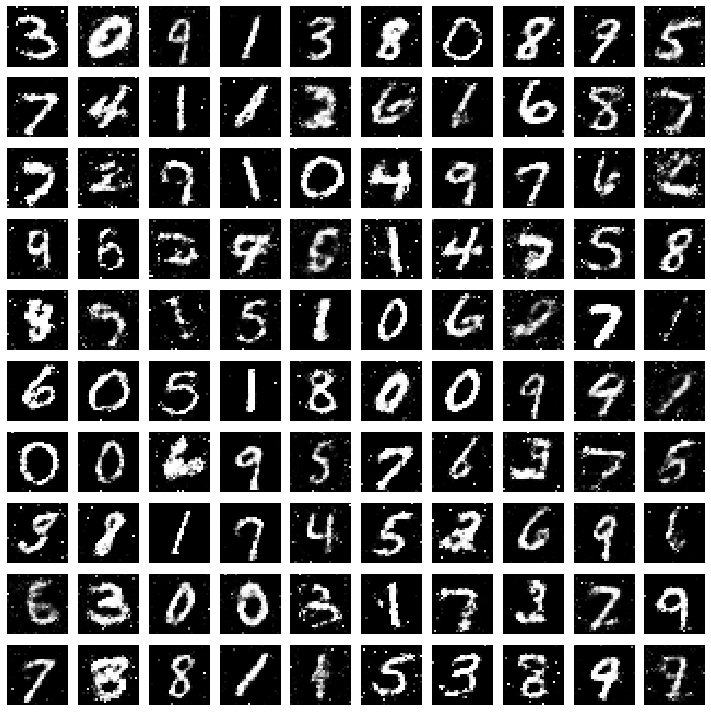

In [65]:
# Training Loop
d_losses = []
g_losses = []


for epoch in range(TOTAL_EPOCHS):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    
    #Mini Batch SGD
    for step in range(NO_OF_BATCHES):
        
        # Step-1 Discriminator 
        # 50% Real Data + 50% Fake Data
        
        #Real Data X
        idx = np.random.randint(0,X_Train.shape[0],HALF_BATCH)
        real_imgs = X_Train[idx]
        
        #Fake Data X
        noise = np.random.normal(0,1,size=(HALF_BATCH,NOISE_DIM))
        fake_imgs = generator.predict(noise) #Forward 
        
        
        # Labels 
        real_y = np.ones((HALF_BATCH,1))*0.9 #One Side Label Smoothing for Discriminator
        fake_y = np.zeros((HALF_BATCH,1))
        
        # Train our Discriminator
        d_loss_real = discriminator.train_on_batch(real_imgs,real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y)
        d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
        
        epoch_d_loss += d_loss
        
        # Train Generator (Considering Frozen Discriminator)
        noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
        ground_truth_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise,ground_truth_y)
        epoch_g_loss += g_loss
    print("Epoch %d Disc Loss %.4f Generator Loss %.4f" %((epoch+1),epoch_d_loss/NO_OF_BATCHES,epoch_g_loss/NO_OF_BATCHES))
    d_losses.append(epoch_d_loss/NO_OF_BATCHES)
    g_losses.append(epoch_g_loss/NO_OF_BATCHES)
    
    if (epoch+1)%5==0:
      generator.save('model/gan_generator_{0}.h5'.format(epoch+1))
      save_imgs(epoch)
        


In [0]:
!ls

In [0]:
!mkdir images

In [0]:
!zip -r/content/images.zip /content/images

In [0]:
from google.colab import files
files.download('images.zip')

In [0]:
plt.plot(d_losses,label="Discriminative_loss")
plt.plot(g_losses,label="generative_loss")
plt.legend()
plt.show()